In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import numpy as np
import pandas as pd

In [3]:
path = Path('/home/jupyter/.fastai/data/humpback')
path.ls()

[PosixPath('/home/jupyter/.fastai/data/humpback/validation_random.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/test.zip'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train.zip'),
 PosixPath('/home/jupyter/.fastai/data/humpback/test'),
 PosixPath('/home/jupyter/.fastai/data/humpback/train'),
 PosixPath('/home/jupyter/.fastai/data/humpback/sample_submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/humpback/models')]

In [4]:
df_label = pd.read_csv(f'{path}/train.csv')
#split validation set
#if train set has at least 3 or more images for a specific class, take 1 to valid
df_test_split = df_label.copy()
df_grouped = df_test_split.groupby('Id').apply(lambda x: x.sample(frac=0.2,random_state=47))
df_merged = pd.merge(left=df_test_split,right=df_grouped,on='Image',how='left',suffixes=('','_y'))
df_merged['is_valid'] = df_merged.Id_y.isnull()!=True
df_merged.drop('Id_y',axis=1,inplace=True)
df_siamese = df_merged[df_merged['Id'] != 'new_whale'].copy()
df_siamese.head()

,Image,Id,is_valid
0,0000e88ab.jpg,w_f48451c,False
1,0001f9222.jpg,w_c3d896a,True
2,00029d126.jpg,w_20df2c5,True
6,000a6daec.jpg,w_dd88965,False
8,0016b897a.jpg,w_64404ac,False


In [5]:
class SiameseDataset(Dataset):
    def __init__(self,ds,stats=imagenet_stats):
        super().__init__()
        self.ds = ds
        self.whale_id = ds.y.items
        self.mean,self.std = imagenet_stats
        
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self,i):
        same = lambda : random.randint(0,1)
        return self.siameseItem(i,same())
    
    def __repr__(self):
        return f'{self.__class__.__name__}\n'+'Total Items List: {}\n'.format(self.__len__())
    
    def siameseItem(self,i,same):
        #print(i)
        #print(self.whale_id[i])
        whale_id = self.ds.inner_df.iloc[i]['Id']
        if same:
            #print(whale_id)
            same_class_list = np.where(self.ds.inner_df['Id'] == whale_id)[0]
            if len(same_class_list) > 1: #has at least 2 images
                same_class_list = np.delete(same_class_list,np.argwhere(same_class_list==i))
            #print('-----',len(same_class_list))
            img_index = same_class_list[np.random.randint(0,len(same_class_list))]
        else:
            diff_class_list = np.where(self.ds.inner_df['Id'] != whale_id)[0]
            img_index = diff_class_list[np.random.randint(0,len(diff_class_list))]
        return self.constructSiamese(i,img_index,same)
    
    
    def constructSiamese(self,img_index,img2_index,same):
        item1 = self.ds[img_index]
        item2 = self.ds[img2_index]
        return ([item1,item2],same)


In [6]:
def normalize_batch(batch):
    x,y = batch
    mean,std = torch.tensor(imagenet_stats).cuda()
    left_imageList_normalized = normalize(x[0][0].cuda(),mean,std)
    right_imageList_normalized = normalize(x[1][0].cuda(),mean,std)
    x[0][0] = left_imageList_normalized
    x[1][0] = right_imageList_normalized
    return (x,y)

In [16]:
bs = 32
size = 224
num_workers = 8

In [17]:
data = (ImageList.from_df(df_siamese,path=path,cols='Image',folder='train')
       .split_from_df(col='is_valid')
       .label_from_df(cols='Id')
       .transform(get_transforms(do_flip=False),size=size,resize_method=ResizeMethod.SQUISH))

In [18]:
train_dl = DataLoader(
    dataset = SiameseDataset(data.train),
    batch_size = bs,
    shuffle = True,
    num_workers = num_workers
)

valid_dl = DataLoader(
    dataset = SiameseDataset(data.valid),
    batch_size = bs,
    num_workers = num_workers
)

In [19]:
data = ImageDataBunch(train_dl,valid_dl)
data.add_tfm(normalize_batch)
data.classes = df_siamese['Id'].unique()
data.c = len(data.classes)

In [20]:
class SiameseNet(nn.Module):
    def __init__(self,arch=models.resnet18):
        super().__init__()
        self.body = create_body(arch)
        self.head = create_head(num_features_model(self.body)*2,128)
        self.linear = nn.Linear(128,1)
        
    
    def forward(self,*xb):
        img_1,img_2 = self.get_Image_Batch(xb)
        #assert(type(img_1) == torch.Tensor)
        #assert(img_1.shape == (64,3,224,224))
        out_put_1 = self.body(img_1)
        out_put_1 = self.head(out_put_1) # bs * 128
        out_put_2 = self.body(img_2)
        out_put_2 = self.head(out_put_2) # bs * 128
        #assert(out_put_1.shape == (64,128))
        #distance = F.pairwise_distance(out_put_1,out_put_2).cuda() #bs * 1
        dl = (out_put_1 - out_put_2).abs_()
        #print(dl.shape,dl)
        distance = self.linear(dl)
        return distance
         
    def get_Image_Batch(self,xb): return xb[0][0],xb[1][0]

In [28]:
learn = Learner(data,SiameseNet().cuda(),loss_func=BCEWithLogitsFlat(),metrics=accuracy)

In [29]:
learn.split([learn.model.body[:6],learn.model.body[6:],learn.model.head])

Learner(data=ImageDataBunch;

Train: SiameseDataset
Total Items List: 13241
;

Valid: SiameseDataset
Total Items List: 2456
;

Test: None, model=SiameseNet(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), st

In [30]:
learn.freeze_to(-1)

In [31]:
learn.lr_find(end_lr=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


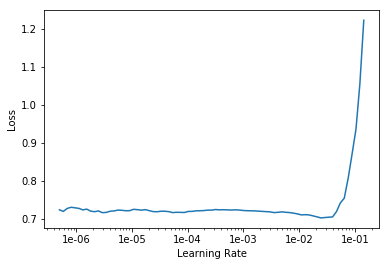

In [32]:
learn.recorder.plot()

In [33]:
lr = 1e-2

In [34]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.578637,0.526826,0.508958,03:51
1,0.467787,0.488478,0.483306,03:19
2,0.434108,0.507963,0.503664,03:17
3,0.406866,0.346827,0.497557,03:21
4,0.366600,0.369593,0.486156,03:18


In [35]:
learn.save('siamese-res18-stage-1-224')

In [36]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


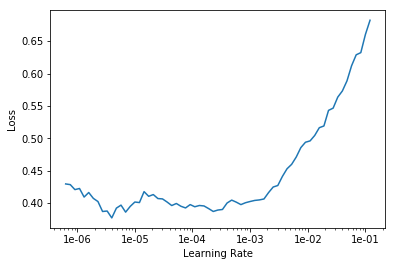

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
lr_2 = 1e-4/2

In [41]:
learn.fit_one_cycle(4,slice(lr_2,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.365433,0.446625,0.488599,03:19
1,0.362359,0.405588,0.497150,03:21
2,0.284024,0.360623,0.504886,03:20
3,0.253341,0.381050,0.491042,03:21


In [42]:
learn.save('siamese-res18-stage-2-224')

In [45]:
acc = partial(accuracy_thresh,sigmoid=False)

In [46]:
preds,y = learn.get_preds()

In [47]:
acc(preds.squeeze(),y)

tensor(0.8416)